# Robust Linear Models

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

## Estimation

Load data:

In [3]:
data = sm.datasets.stackloss.load()
data.exog = sm.add_constant(data.exog)

Huber's T norm with the (default) median absolute deviation scaling

In [4]:
huber_t = sm.RLM(data.endog, data.exog, M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()
print(hub_results.params)
print(hub_results.bse)
print(
    hub_results.summary(
        yname="y", xname=["var_%d" % i for i in range(len(hub_results.params))]
    )
)

const       -41.026498
AIRFLOW       0.829384
WATERTEMP     0.926066
ACIDCONC     -0.127847
dtype: float64
const        9.791899
AIRFLOW      0.111005
WATERTEMP    0.302930
ACIDCONC     0.128650
dtype: float64
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   21
Model:                            RLM   Df Residuals:                       17
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 08 Jan 2026                                         
Time:                        12:51:58                                         
No. Iterations:                    19                                         


Huber's T norm with 'H2' covariance matrix

In [5]:
hub_results2 = huber_t.fit(cov="H2")
print(hub_results2.params)
print(hub_results2.bse)

const       -41.026498
AIRFLOW       0.829384
WATERTEMP     0.926066
ACIDCONC     -0.127847
dtype: float64
const        9.089504
AIRFLOW      0.119460
WATERTEMP    0.322355
ACIDCONC     0.117963
dtype: float64


Andrew's Wave norm with Huber's Proposal 2 scaling and 'H3' covariance matrix

In [6]:
andrew_mod = sm.RLM(data.endog, data.exog, M=sm.robust.norms.AndrewWave())
andrew_results = andrew_mod.fit(scale_est=sm.robust.scale.HuberScale(), cov="H3")
print("Parameters: ", andrew_results.params)

Parameters:  const       -40.881796
AIRFLOW       0.792761
WATERTEMP     1.048576
ACIDCONC     -0.133609
dtype: float64


See ``help(sm.RLM.fit)`` for more options and ``module sm.robust.scale`` for scale options

## Comparing OLS and RLM

Artificial data with outliers:

In [7]:
nsample = 50
x1 = np.linspace(0, 20, nsample)
X = np.column_stack((x1, (x1 - 5) ** 2))
X = sm.add_constant(X)
sig = 0.3  # smaller error variance makes OLS<->RLM contrast bigger
beta = [5, 0.5, -0.0]
y_true2 = np.dot(X, beta)
y2 = y_true2 + sig * 1.0 * np.random.normal(size=nsample)
y2[[39, 41, 43, 45, 48]] -= 5  # add some outliers (10% of nsample)

### Example 1: quadratic function with linear truth

Note that the quadratic term in OLS regression will capture outlier effects. 

In [8]:
res = sm.OLS(y2, X).fit()
print(res.params)
print(res.bse)
print(res.predict())

[ 5.24243796  0.49403097 -0.01112318]
[0.46129619 0.07121791 0.00630169]
[ 4.96435845  5.20955139  5.45103814  5.68881871  5.9228931   6.15326131
  6.37992334  6.60287918  6.82212884  7.03767231  7.24950961  7.45764072
  7.66206565  7.8627844   8.05979696  8.25310334  8.44270354  8.62859756
  8.81078539  8.98926705  9.16404252  9.3351118   9.50247491  9.66613183
  9.82608257  9.98232713 10.1348655  10.2836977  10.42882371 10.57024353
 10.70795718 10.84196464 10.97226592 11.09886102 11.22174993 11.34093267
 11.45640922 11.56817958 11.67624377 11.78060177 11.88125359 11.97819923
 12.07143869 12.16097196 12.24679905 12.32891996 12.40733468 12.48204323
 12.55304559 12.62034176]


Estimate RLM:

In [9]:
resrlm = sm.RLM(y2, X).fit()
print(resrlm.params)
print(resrlm.bse)

[ 5.18437797e+00  4.79777791e-01 -8.27819160e-04]
[0.13008339 0.02008312 0.00177705]


Draw a plot to compare OLS estimates to the robust estimates:

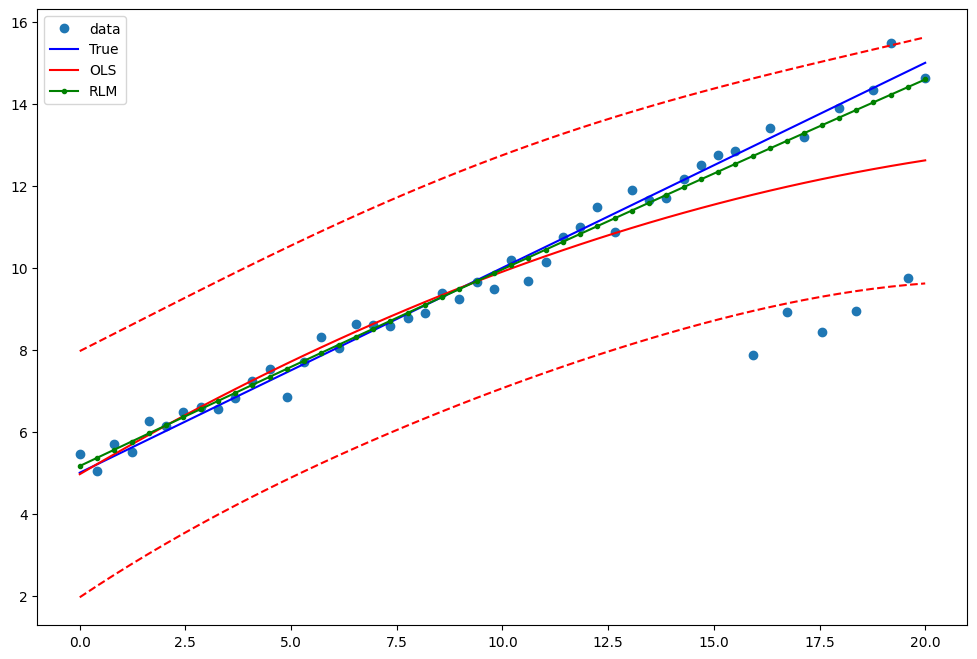

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(x1, y2, "o", label="data")
ax.plot(x1, y_true2, "b-", label="True")
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

ax.plot(x1, res.fittedvalues, "r-", label="OLS")
ax.plot(x1, iv_u, "r--")
ax.plot(x1, iv_l, "r--")
ax.plot(x1, resrlm.fittedvalues, "g.-", label="RLM")
ax.legend(loc="best")

### Example 2: linear function with linear truth

Fit a new OLS model using only the linear term and the constant:

In [11]:
X2 = X[:, [0, 1]]
res2 = sm.OLS(y2, X2).fit()
print(res2.params)
print(res2.bse)

[5.69077022 0.38279917]
[0.39346595 0.03390262]


Estimate RLM:

In [12]:
resrlm2 = sm.RLM(y2, X2).fit()
print(resrlm2.params)
print(resrlm2.bse)

[5.20762503 0.47344398]
[0.10200247 0.00878895]


Draw a plot to compare OLS estimates to the robust estimates:

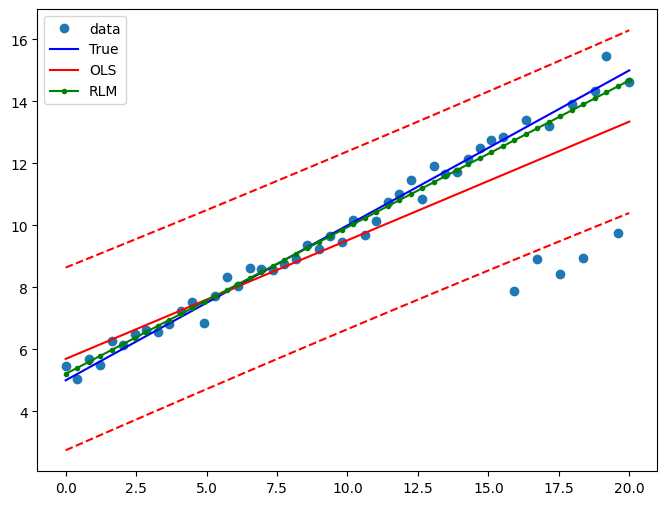

In [13]:
pred_ols = res2.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x1, y2, "o", label="data")
ax.plot(x1, y_true2, "b-", label="True")
ax.plot(x1, res2.fittedvalues, "r-", label="OLS")
ax.plot(x1, iv_u, "r--")
ax.plot(x1, iv_l, "r--")
ax.plot(x1, resrlm2.fittedvalues, "g.-", label="RLM")
legend = ax.legend(loc="best")